In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix

In [4]:
# Load dataset
train = pd.read_csv('/content/emotion-labels-train.csv')
test = pd.read_csv('/content/emotion-labels-test.csv')
# Combine training and test datasets
train = pd.concat([train, test], axis=0)
train.head()

,text,label
0,Just got back from seeing @GaryDelaney in Burs...,joy
1,Oh dear an evening of absolute hilarity I don'...,joy
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy
4,I feel so blessed to work with the family that...,joy


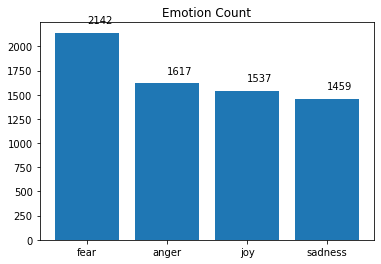

In [6]:
# Plot the label count
plt.bar(train['label'].value_counts().index, list(train['label'].value_counts()))
for index, value in enumerate(list(train['label'].value_counts())):
    plt.text(index, value+100, str(value))
plt.title('Emotion Count')
plt.show()

In [7]:
print('Number of training data observations ' + str(train.shape[0]))

Number of training data observations 6755


In [10]:
# One-hot-encoding
trainSet = train.reset_index(drop=True)
labels = pd.get_dummies(trainSet['label'])
trainSet = pd.concat([trainSet, labels], axis=1)
trainSet.head()

,text,label,anger,fear,joy,sadness
0,Just got back from seeing @GaryDelaney in Burs...,joy,0,0,1,0
1,Oh dear an evening of absolute hilarity I don'...,joy,0,0,1,0
2,Been waiting all week for this game ❤️❤️❤️ #ch...,joy,0,0,1,0
3,"@gardiner_love : Thank you so much, Gloria! Yo...",joy,0,0,1,0
4,I feel so blessed to work with the family that...,joy,0,0,1,0


In [11]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(trainSet['text'].values,
                                                  trainSet[['anger','fear','joy','sadness']].values,
                                                  stratify=trainSet['label'],
                                                  test_size=0.2, random_state=123)

In [12]:
# Apply tokenizer and sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(X_train) 
tokenizer.fit_on_texts(X_val)
 
seq_train = tokenizer.texts_to_sequences(X_train)
seq_val = tokenizer.texts_to_sequences(X_val)
 
pad_train = pad_sequences(seq_train) 
pad_val = pad_sequences(seq_val)

In [13]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [14]:
# Create the model
lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.SpatialDropout1D(0.3),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])
lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
class earlystop(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.855):
      print("\nAkurasi telah mencapai > 85%!")
      self.model.stop_training = True
es = earlystop()

history = lstm.fit(pad_train, y_train, epochs=100, callbacks=[es],
                   validation_data=(pad_val, y_val), verbose=2, batch_size=100)

Epoch 1/100
55/55 - 5s - loss: 0.0348 - accuracy: 0.9771 - val_loss: 2.1571 - val_accuracy: 0.8505
Epoch 2/100
55/55 - 5s - loss: 0.0400 - accuracy: 0.9750 - val_loss: 1.9905 - val_accuracy: 0.8460
Epoch 3/100
55/55 - 5s - loss: 0.0386 - accuracy: 0.9728 - val_loss: 2.0930 - val_accuracy: 0.8386
Epoch 4/100
55/55 - 5s - loss: 0.0377 - accuracy: 0.9741 - val_loss: 2.0917 - val_accuracy: 0.8505
Epoch 5/100
55/55 - 5s - loss: 0.0392 - accuracy: 0.9743 - val_loss: 2.1664 - val_accuracy: 0.8431
Epoch 6/100
55/55 - 5s - loss: 0.0377 - accuracy: 0.9739 - val_loss: 1.8948 - val_accuracy: 0.8512
Epoch 7/100
55/55 - 5s - loss: 0.0353 - accuracy: 0.9782 - val_loss: 2.3116 - val_accuracy: 0.8564

Akurasi telah mencapai > 85%!


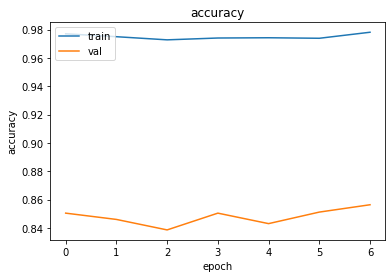

In [28]:
# Visualize LSTM history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()